In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('..')

from lib import *
from lib.maxent import *
from lib.plotting import *
plt.style.use('../peptidome.mplstyle')

%load_ext autoreload
%autoreload 2

In [2]:
k = 9
proteome = 'Human'

In [3]:
matrix = load_matrix('../maxent/data/{proteome}_test_k{k}_matrix.csv.gz'.format(proteome=proteome, k=k))

In [4]:
params = np.load('../maxent/data/Human_nskewfcov_k9_params.npz')
energy = make_energy(params)

In [5]:
likelihood_human = np.array([-energy(x) for x in matrix])

In [8]:
with open(datadir+ 'triplet-%s.json' % proteome.lower(), 'r') as f:
    tripletparams = json.load(f)
loglikelihood = lambda seq, k: -energy(map_aatonumber(seq.upper()))
likelihoodname = 'maxent'

In [9]:
df_ts = load_iedb_tcellepitopes()

In [10]:
host = 'Homo sapiens'
#host = 'Mus musculus'
mask_host_host = df_ts['Host', 'Name'].str.contains(host, na=False)
# no host epitopes or epitopes of unknown provenance
mask_epitope_host = df_ts['Epitope', 'Parent Species'].str.contains(host, na=True)
df_ts = df_ts[mask_host_host & (~mask_epitope_host)]

In [ ]:
# uniquify epitopes by keeping only the first one
df_ts = df_ts.groupby(('Epitope', 'Description')).apply(lambda x: x.iloc[0])

(array([0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 2.1000e+01,
        1.7000e+01, 1.9000e+01, 9.1600e+02, 2.9118e+04, 1.3792e+04,
        1.1380e+03, 3.8700e+03, 1.9390e+03, 1.8690e+03, 9.8434e+04,
        3.6820e+03, 3.9680e+03, 7.2150e+03, 9.5900e+02, 2.2122e+04,
        5.4200e+02, 3.8200e+02, 2.2000e+02]),
 array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5]),
 <BarContainer object of 23 artists>)

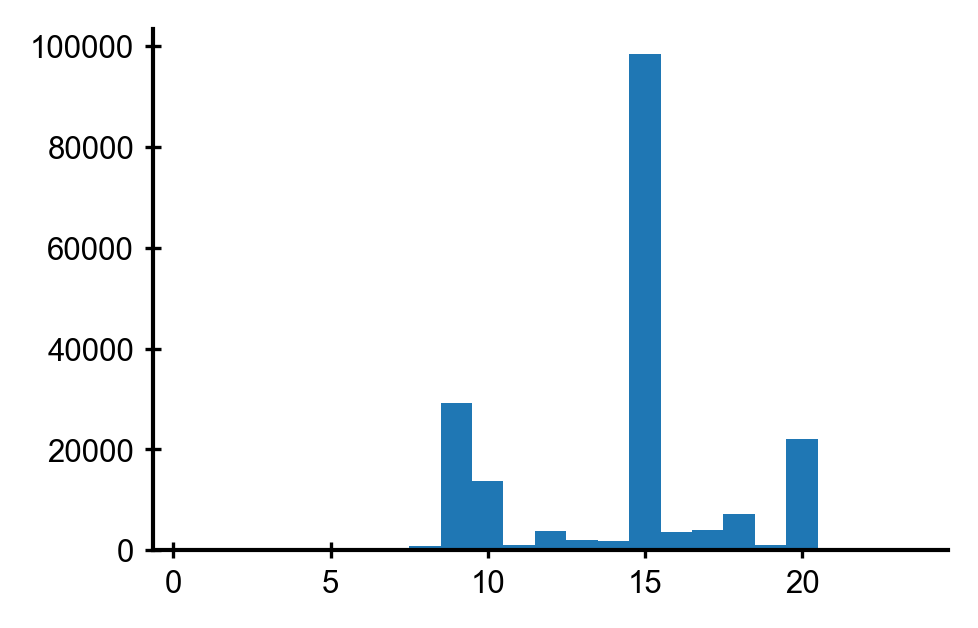

In [11]:
plt.hist(df_ts['Epitope', 'Description'].str.len(), bins=np.arange(1, 25, 1)-0.5)

In [30]:
xmin = likelihood_human.min()
xmax = likelihood_human.max()
hists_pos = {}
hists_neg = {}
lengths = [9, 15]
for length in lengths:
    positive = ~(df_ts['Assay', 'Qualitative Measure'] == 'Negative')
    lengthmask = np.abs(df_ts['Epitope', 'Description'].str.len()-length)<1
    likelihoods_t, weights_t = likelihoods_epitopes(df_ts[positive & lengthmask]['Epitope', 'Description'], loglikelihood, k)
    likelihoods_t_neg, weights_t_neg = likelihoods_epitopes(df_ts[(~positive) & lengthmask]['Epitope', 'Description'], loglikelihood, k)

    #bins = list(np.linspace(xmin+3, xmax-8, 25))
    bins = list(np.linspace(xmin, xmax, 10))
    bins.extend([xmin-0.1, xmax+0.1])
    bins = np.array(sorted(bins))
    binmids = (bins[1:]+bins[:-1])*0.5
    hists_pos[length] = np.histogram(likelihoods_t, bins=bins, weights=weights_t)[0]
    hists_neg[length]= np.histogram(likelihoods_t_neg, bins=bins, weights=weights_t_neg)[0]

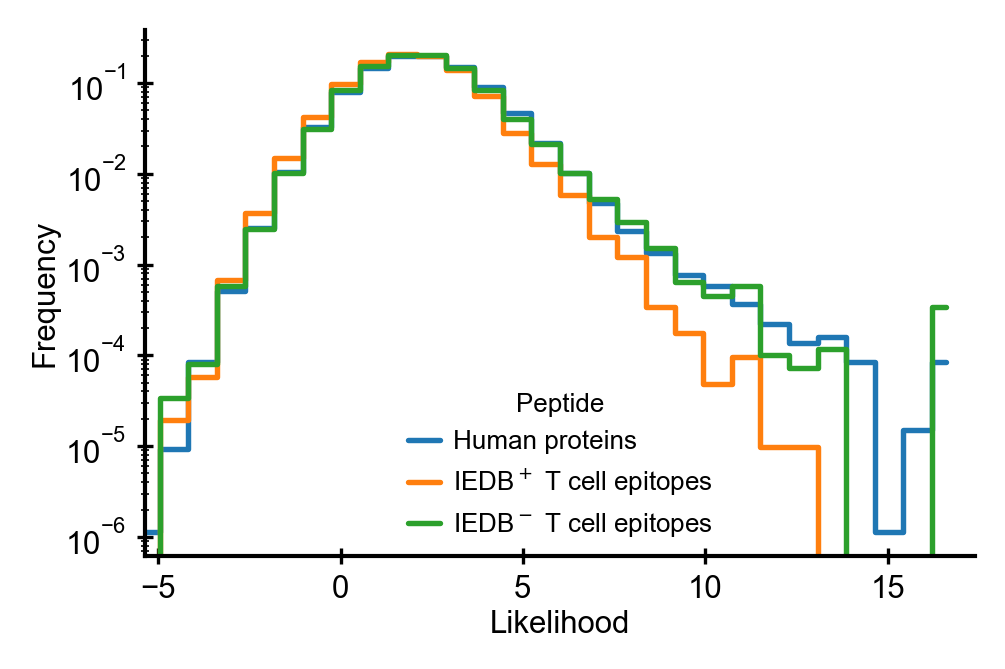

In [31]:
fig, ax = plt.subplots()
ps = [likelihood_human, likelihoods_t, likelihoods_t_neg]#, likelihoods_b]
labels = ['Human proteins', 'IEDB$^+$ T cell epitopes', 'IEDB$^-$ T cell epitopes']#, 'B epitopes']
weights = [np.ones(len(likelihood_human)), weights_t, weights_t_neg]#, weights_b]

plot_histograms(ps, labels, weights=weights, xmin=xmin, xmax=xmax, ax=ax, nbins=30)
ax.set_xlim(xmin, xmax)
ax.set_ylabel('Frequency')
ax.set_xlabel('Likelihood')
ax.set_yscale('log')
ax.legend(title='Peptide', loc='lower center')
fig.tight_layout()

/home/amayer/anaconda3/envs/py3/lib/python3.8/site-packages/statsmodels/stats/proportion.py:90: RuntimeWarning: invalid value encountered in true_divide
  q_ = count * 1. / nobs
/home/amayer/anaconda3/envs/py3/lib/python3.8/site-packages/statsmodels/stats/proportion.py:90: RuntimeWarning: invalid value encountered in true_divide
  q_ = count * 1. / nobs


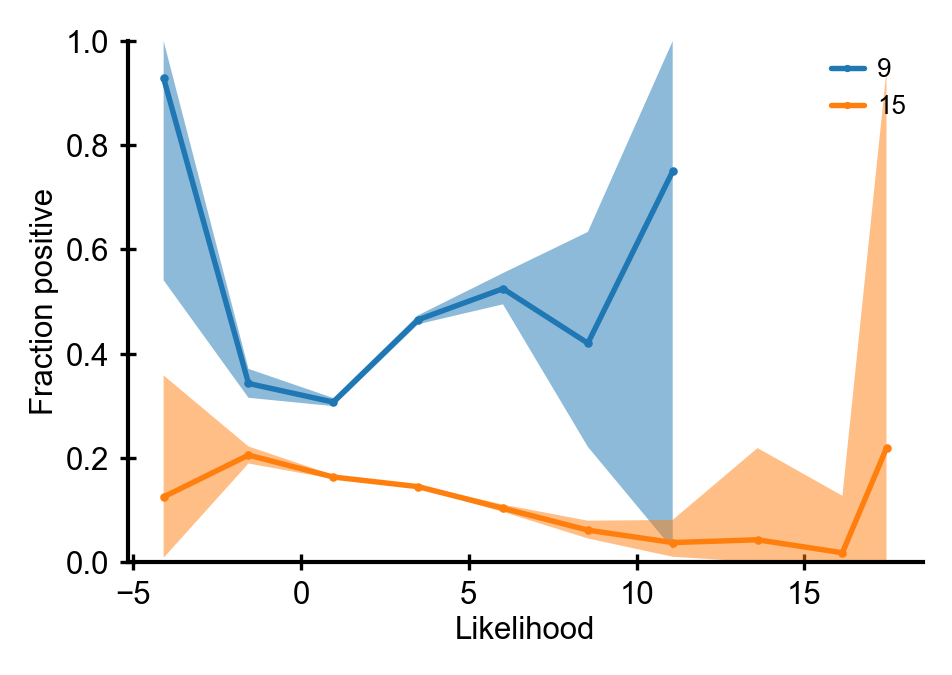

In [33]:
fig, ax = plt.subplots()
for length in lengths:
    hist_pos, hist_neg = hists_pos[length], hists_neg[length]
    plot_proportion(binmids, hist_pos, hist_pos+hist_neg, ls='-', marker='.', ax=ax, label=length)
ax.set_xlabel('Likelihood')
ax.set_ylabel('Fraction positive')
ax.legend()
ax.set_ylim(0.0, 1.0)
fig.savefig('maxent_iedb_fraction_positive.png')